In [3]:
import os, re, json, string
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
from models.utils import *
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/opt/anaconda3/envs/meta-prompting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [7]:
model_name   = "gpt2"   # oppure "gpt2-medium", "EleutherAI/gpt-neo-1.3B", "mistralai/Mistral-7B-v0.1", ecc.
prompt       = "You are an AI language model tasked with writing short and imaginative fairy tales. In each case, you will be asked to write a fairy tale that blends two contrasting narrative genres. Do not assume any prior context or style. Simply respond with a complete and coherent fairy tale based solely on the genres provided. Use clear language and avoid adding your own framing or interpretations."
max_new_tok  = 250
n_sentences  = 4
temperature  = 0.7
top_p        = 0.95
top_k        = 50
out_dir      = "gpt2_test"
drop_punct_from_loss = True   # opzione per ridurre il peso di .,,
os.makedirs(out_dir, exist_ok=True)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

prompt_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
prompt_len = prompt_ids.shape[1]

full_ids, scores = generate_with_scores(
    model,
    prompt_ids,
    max_new_tokens=max_new_tok,
    do_sample=True,
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    pad_token_id=tokenizer.eos_token_id
)

gen_ids        = full_ids[0, prompt_len:]
generated_text = tokenizer.decode(gen_ids, skip_special_tokens=True)

# Logprobs dataframe
logprobs = compute_logprobs(scores, gen_ids)
log_df = pd.DataFrame({
    "step": range(1, len(gen_ids)+1),
    "token_id": gen_ids.cpu().tolist(),
    "token_str": tokenizer.convert_ids_to_tokens(gen_ids.cpu().tolist()),
    "logprob": logprobs
})
log_df["surprisal"] = -log_df["logprob"]
display(log_df.head())

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Prime 3 frasi (106 token):
The first of its kind, the book of poems, inspired by the French fairy tale, has been published in the United States. The story of a young boy named Louis, whose parents have died and his only sister is dead, is not only a fairy tale but also a serious drama in the American way of life.

"The story of Louis is a story about a young man who is a hero to his people, but he is also a man of mystery and mystery about who he is, and about his destiny.



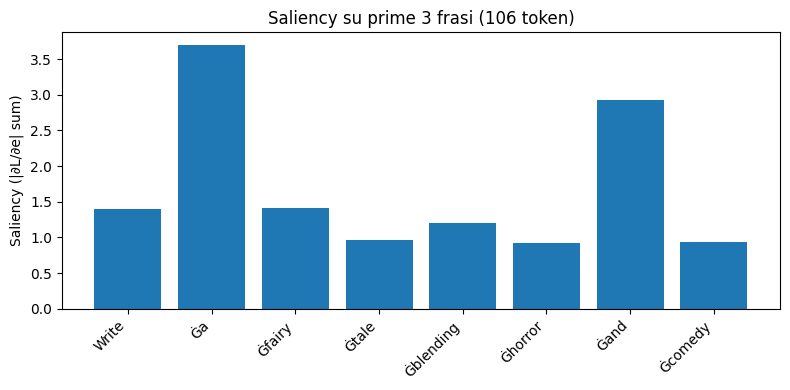

In [16]:
focus_text = split_first_n_sentences(generated_text, n_sentences)
focus_ids  = tokenizer(focus_text, return_tensors="pt", add_special_tokens=False).input_ids[0].to(device)
focus_len  = focus_ids.shape[0]

print(f"Prime {n_sentences} frasi ({focus_len} token):\n{focus_text}\n")

sal_scores = compute_saliency_manual(
    model, full_ids, prompt_len, focus_len, device,
    drop_punct=drop_punct_from_loss, tokenizer=tokenizer
)

prompt_tokens = tokenizer.convert_ids_to_tokens(full_ids[0, :prompt_len].cpu().tolist())
plot_saliency(prompt_tokens, sal_scores,
              title=f"Saliency su prime {n_sentences} frasi ({focus_len} token)")

,word,score
1,a,3.690087
6,and,2.922061
2,fairy,1.415755
0,Write,1.400161
4,blending,1.199699
3,tale,0.965431
7,comedy,0.931455
5,horror,0.923824


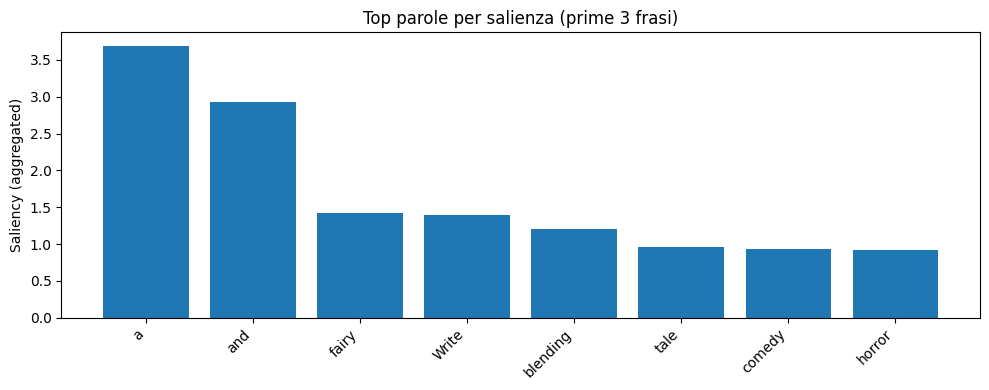

In [17]:
# Aggrego per parola
df_words = aggregate_bpe(prompt_tokens, sal_scores)

# Mostra le top parole
display(df_words.sort_values("score", ascending=False).head(20))

# Plot
plot_word_saliency(df_words, top_n=20,
                   title=f"Top parole per salienza (prime {n_sentences} frasi)")

In [18]:
import json, os
os.makedirs(out_dir, exist_ok=True)

# Salvataggi
pd.DataFrame({"token": prompt_tokens,
              "score": sal_scores.cpu().numpy()}).to_csv(f"{out_dir}/saliency_tokens.csv", index=False)
df_words.to_csv(f"{out_dir}/saliency_words.csv", index=False)
log_df.to_csv(f"{out_dir}/logprobs.csv", index=False)

with open(f"{out_dir}/meta.json", "w", encoding="utf-8") as f:
    json.dump({
        "prompt": prompt,
        "full_generation": generated_text,
        "first_n_sentences": focus_text,
        "model": model_name,
        "n_sentences": n_sentences,
        "total_generated_tokens": int(len(gen_ids)),
        "focus_tokens": int(len(focus_ids))
    }, f, ensure_ascii=False, indent=2)

print("Esportato tutto in:", out_dir)

Esportato tutto in: run_xai
